In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import tensorflow as tf
import random

In [2]:
# Set up a random seed for reproducibility
np.random.seed(4)

In [3]:
# Set the working path and read in housing transactions data
path = r'C:\Users\wanh535\OneDrive - PNNL\Desktop\ICoM data\Historic Housing Prices\Static Multiple Linear Regression\\'
prices = pd.read_csv(path + 'synthetic_housing_data.csv')

In [9]:
# Print out the data statistics
pd.set_option('display.float_format', lambda x: '%.1f' % x)
prices.describe()

,SalesPriceAmount,Area,Age,Stories,Baths,LotSize,CenterDist,Years
count,482629.0,482629.0,482629.0,482629.0,482629.0,482629.0,482629.0,482629.0
mean,285515.6,2154.3,30.6,1.7,2.1,23496.3,24562.4,15.1
std,217872.0,1011.6,28.2,0.4,0.8,33680.0,14235.5,6.2
min,10000.0,423.0,0.0,1.0,1.0,435.0,2426.6,3.0
25%,143631.0,1442.0,0.0,1.5,2.0,7021.6,13250.7,10.0
50%,225849.0,1881.0,28.0,2.0,2.0,10210.1,20676.8,15.0
75%,354938.0,2508.0,51.0,2.0,3.0,24696.8,35931.6,19.0
max,1700169.0,8461.0,222.0,2.5,5.0,249773.0,71176.4,29.0


In [17]:
# Obtain response variable and predictors
predictors = prices.drop(['SalesPriceAmount'], axis = 1)
Y = prices['SalesPriceAmount']

X = np.array(predictors)
Y = np.array(Y)

In [20]:
# Split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
# Sdandarize the variables
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test = sc_y.transform(Y_test.reshape(-1, 1)).ravel()

In [22]:
# Split the training set into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Grid search for ANN hyperparameters

In [23]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(x_train, y_train, x_val, y_val, x_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[16, 32, 64, 128]
    learning_rate_list = [0.0001, 0.001, 0.1]
    N_neuron1 = [16, 32, 64, 128, 256]
    N_neuron2 = [16, 32, 64, 128, 256]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'RMSE'])
    
    # initializing the trials
    TrialNumber=0
    for learning_rate in learning_rate_list:
        for batch_size_trial in batch_size_list:
            for number1 in N_neuron1:
                for number2 in N_neuron2:
                    TrialNumber+=1
                    # create ANN model
                    import tensorflow as tf
                    model = tf.keras.models.Sequential()

                    # Defining the first layer of the model
                    model.add(tf.keras.layers.Dense(units=number1, activation='relu', input_dim=X.shape[1]))

                    # Defining the Second layer of the model
                    model.add(tf.keras.layers.Dense(units=number2, activation='relu'))

                    # The output neuron is a single fully connected node 
                    # Since we will be predicting a single number
                    model.add(tf.keras.layers.Dense(units=1, activation='linear'))

                    # Compiling the model
                    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                    model.compile(loss='mean_squared_error', optimizer=optimizer)
            
                    from keras.callbacks import EarlyStopping
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

                    # Fitting the ANN to the Training set
                    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, 
                              batch_size=batch_size_trial, callbacks=[early_stopping], verbose = 0)
            
                    from sklearn.metrics import mean_squared_error
                    rmse = np.sqrt(mean_squared_error(model.predict(x_test), Y_test))
            
                    # printing the results of the current iteration
                    print(TrialNumber, 'Parameters:','learning_rate', learning_rate, '-', 'batch_size:', 
                          batch_size_trial,'-', 'N_neurons1:',number1, 'N_neurons1', number2, 'RMSE:', rmse)
            
                    SearchResultsData=SearchResultsData.append(pd.DataFrame(
                        data=[[TrialNumber, str(learning_rate)+'-'+str(batch_size_trial)+'-'+str(number1)+'-'+
                               str(number2), rmse]],columns=['TrialNumber', 'Parameters', 'RMSE']))
                
    return(SearchResultsData)


# ANN model

In [24]:
print(tf.__version__)

tf.random.set_seed(1)
random.seed(1)
model1=tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=X.shape[1]))
model1.add(tf.keras.layers.Dense(units=128, activation='relu'))
model1.add(tf.keras.layers.Dense(units=1, activation='linear'))
#compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.summary()

tf.random.set_seed(2)
random.seed(2)
model2=tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=X.shape[1]))
model2.add(tf.keras.layers.Dense(units=128, activation='relu'))
model2.add(tf.keras.layers.Dense(units=1, activation='linear'))
#compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

tf.random.set_seed(3)
random.seed(3)
model3=tf.keras.models.Sequential()
model3.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=X.shape[1]))
model3.add(tf.keras.layers.Dense(units=128, activation='relu'))
model3.add(tf.keras.layers.Dense(units=1, activation='linear'))
#compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

tf.random.set_seed(4)
random.seed(4)
model4=tf.keras.models.Sequential()
model4.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=X.shape[1]))
model4.add(tf.keras.layers.Dense(units=128, activation='relu'))
model4.add(tf.keras.layers.Dense(units=1, activation='linear'))
#compile the model
model4.compile(optimizer='adam', loss='mean_squared_error')

tf.random.set_seed(5)
random.seed(5)
model5=tf.keras.models.Sequential()
model5.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=X.shape[1]))
model5.add(tf.keras.layers.Dense(units=128, activation='relu'))
model5.add(tf.keras.layers.Dense(units=1, activation='linear'))
#compile the model
model5.compile(optimizer='adam', loss='mean_squared_error')


2.18.0


C:\Users\wanh535\AppData\Local\anaconda3\envs\spatial_python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose = 0)
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose = 0)
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose = 0)
history4 = model4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose = 0)
history5 = model5.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose = 0)


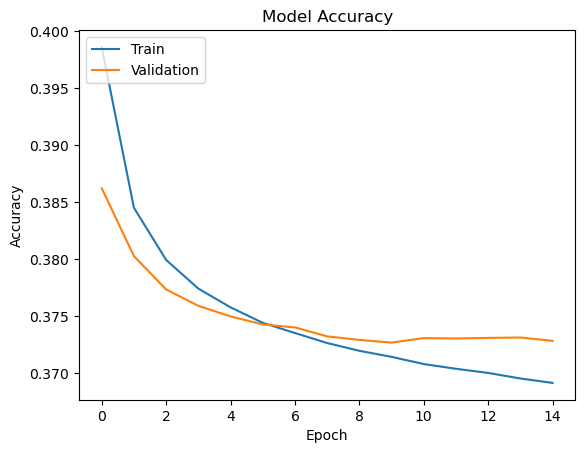

In [27]:
# Plot the accuracy vs. epochs
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Accuracy Assessment

In [28]:
#Accuracy assessment function
def accuracy_assessment(X_data, Y_data, model):
    pred = model.predict(X_data)
    from sklearn.metrics import mean_squared_error
    print("Standardized RMSE is: ", np.sqrt(mean_squared_error(pred, Y_data.reshape(-1, 1))))
    pred_inverse = sc_y.inverse_transform(pred)
    #     pred_inverse[pred_inverse<10000] = 10000
    Y_data_inverse = sc_y.inverse_transform(Y_data.reshape(-1, 1))
    from sklearn.metrics import r2_score
    r2 = r2_score(Y_data_inverse, pred_inverse)
    print('R^2 is:', r2)
    APE = 100*(abs(Y_data_inverse - pred_inverse)/Y_data_inverse)
    print('MAPE is:', np.mean(APE), '%')
    print('MdAPE is:', np.median(APE), '%')
    print("Original RMSE is:", np.sqrt(mean_squared_error(pred_inverse, Y_data_inverse)))
    print("RMSE normalized by range is: ", 100 * np.sqrt(
        mean_squared_error(pred_inverse, Y_data_inverse)) / (Y.max() - Y.min()), "%")
    print("RMSE normalized by mean is: ", 100 * np.sqrt(
        mean_squared_error(pred_inverse, Y_data_inverse)) / Y.mean(), "%")

In [111]:
# Change the model from 1 to 5 to assess the accuracy individually. The final accuracy should be the average of the 5 models.
accuracy_assessment(x_train, y_train, model5)

9653/9653 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Standardized RMSE is:  0.6056940751822798
R^2 is: 0.6327206151956281
MAPE is: 43.215205363690515 %
MdAPE is: 27.111761426847053 %
Original RMSE is: 131917.3832596812
RMSE normalized by range is:  7.804981824875572 %
RMSE normalized by mean is:  46.20321409433363 %


In [112]:
accuracy_assessment(x_val, y_val, model5)

2414/2414 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Standardized RMSE is:  0.6106603665019136
R^2 is: 0.6287676594702991
MAPE is: 43.39359895416002 %
MdAPE is: 27.310370799274413 %
Original RMSE is: 132999.01858027227
RMSE normalized by range is:  7.868977515282334 %
RMSE normalized by mean is:  46.58204990091483 %


In [113]:
accuracy_assessment(X_test, Y_test, model5)

3017/3017 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Standardized RMSE is:  0.6143762977683437
R^2 is: 0.6238564335330892
MAPE is: 43.15751242548567 %
MdAPE is: 27.19299071220893 %
Original RMSE is: 133808.3314280838
RMSE normalized by range is:  7.916861061117782 %
RMSE normalized by mean is:  46.865506514840554 %


# Partial dependence plot

In [90]:
col_names = predictors.columns.tolist()
col_names

['Area', 'Age', 'Stories', 'Baths', 'LotSize', 'CenterDist', 'Years']

In [91]:
#Create a function for one-way Partial Dependence Plot
from sklearn.inspection import partial_dependence
def plot_2d(var):
    index = col_names.index(var)
    x_grid = np.zeros((50, len(col_names)))
    x_grid[:, index] = np.linspace(X_train[:, index].min(), X_train[:, index].max(), 50)
    
    prediction = np.concatenate([model1.predict(x_grid), model2.predict(x_grid), model3.predict(x_grid), 
                                model4.predict(x_grid), model5.predict(x_grid)], axis = 1)
    y_pred = np.mean(prediction, axis = 1)
    y_pred = sc_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    x_grid = sc_x.inverse_transform(x_grid)
    

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.plot(x_grid[:, index], y_pred)
    ax.set_ylim([10000, 750000])
    ax.set_xlabel(f'{var}', fontsize = 25)
    ax.set_ylabel('Sales Price', fontsize = 25)
    
    plt.xticks(fontsize=16) 
    plt.yticks(fontsize=16)
    plt.subplots_adjust(left=0.2, right=0.96, bottom=0.1, top=0.98)
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


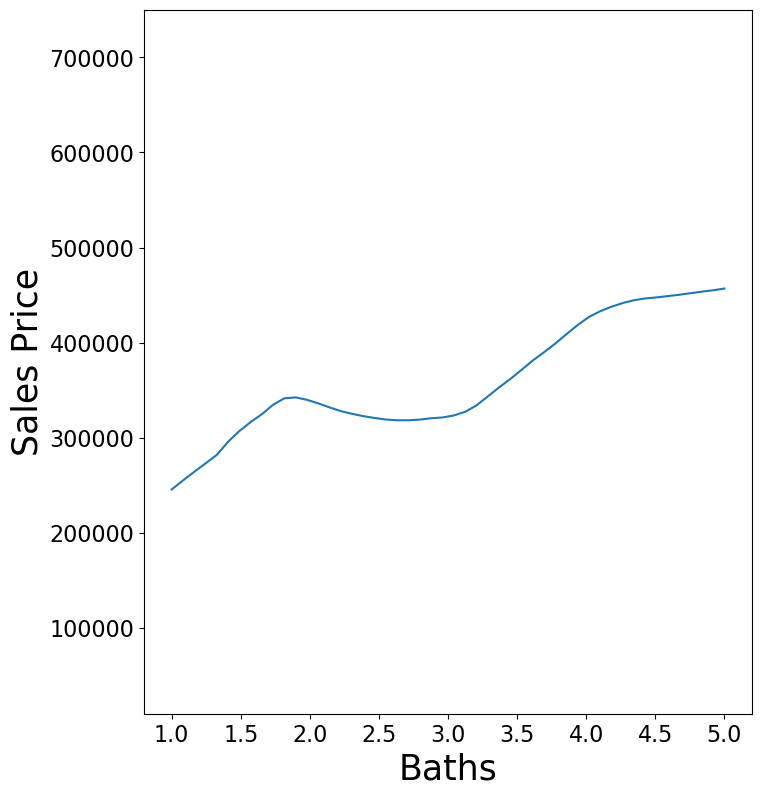

In [92]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("Baths")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


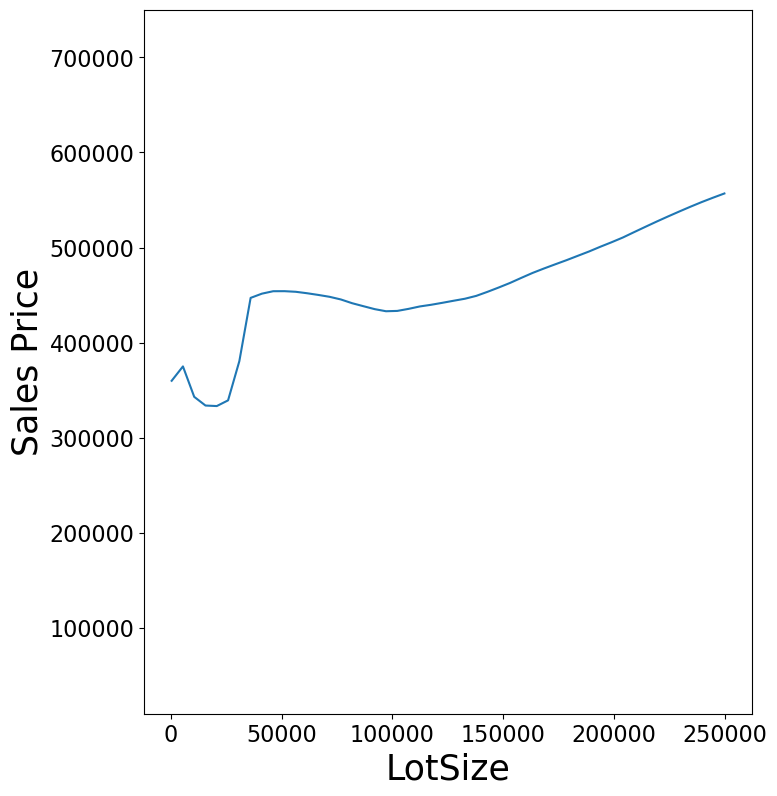

In [93]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("LotSize")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


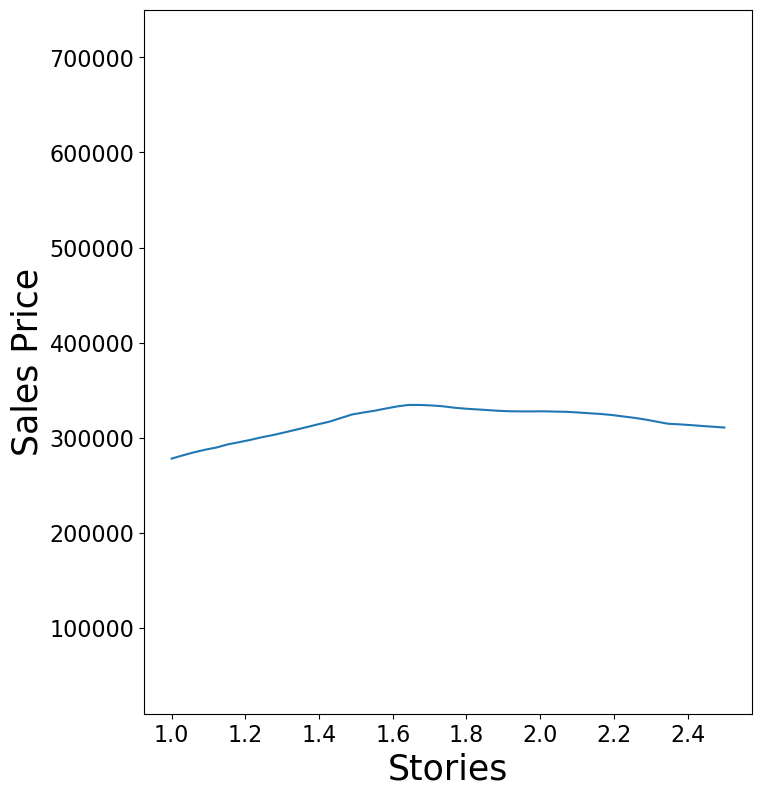

In [94]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("Stories")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


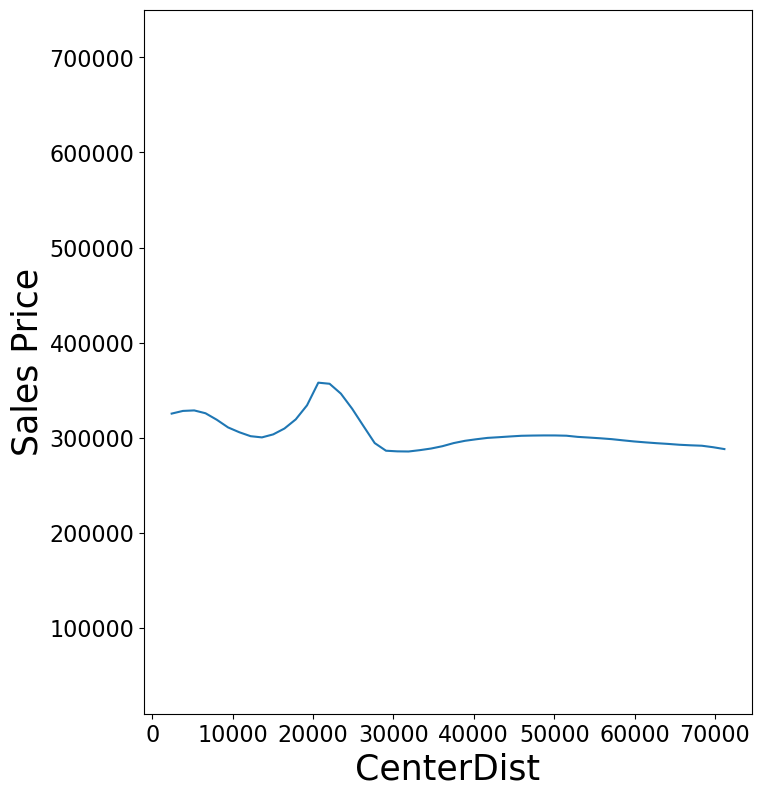

In [95]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("CenterDist")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


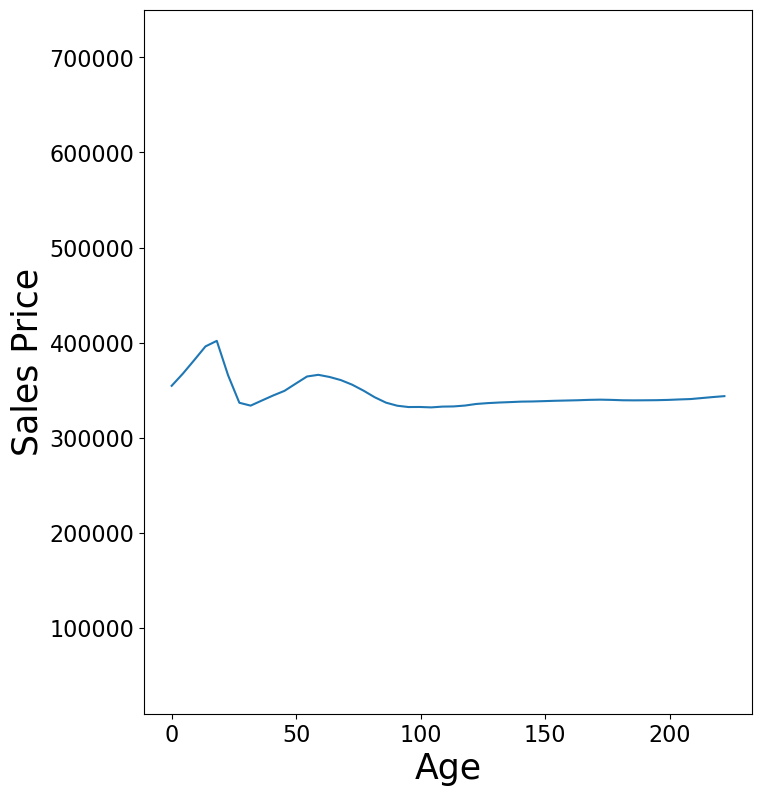

In [96]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("Age")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


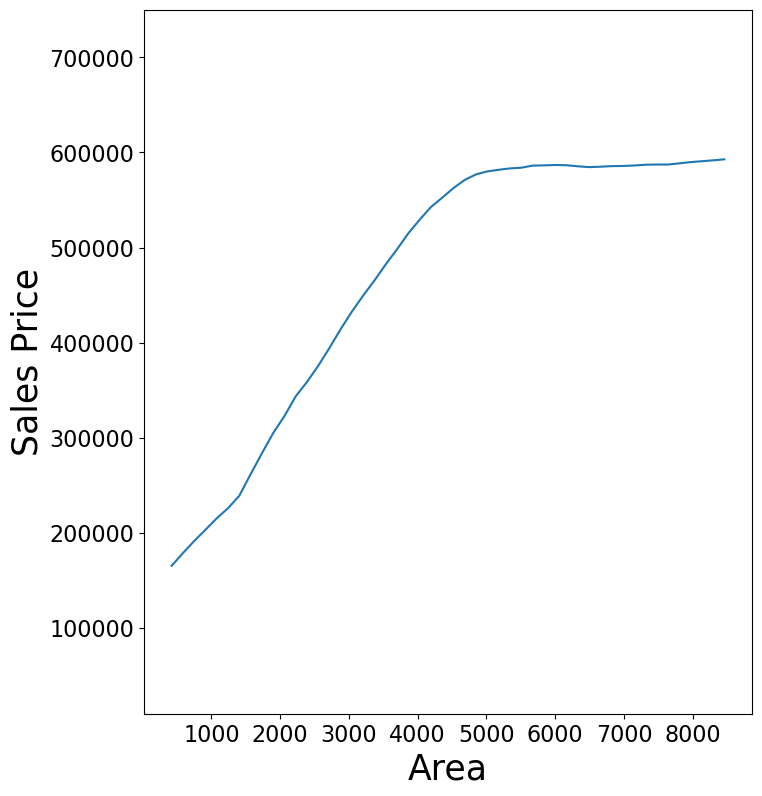

In [97]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("Area")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


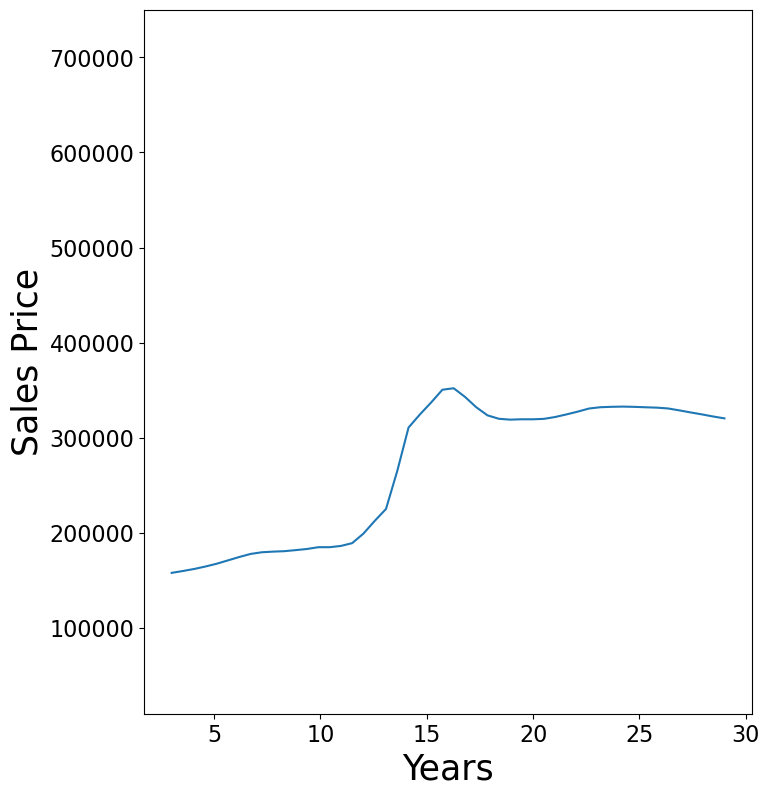

In [98]:
# Plot the one-way partial dependence plot
%matplotlib inline
plot_2d("Years")

In [67]:
#Create a function for two-way Partial Dependence Plot
from matplotlib.ticker import ScalarFormatter
def plot_3d(var1, var2):
    index1 = col_names.index(var1)
    index2 = col_names.index(var2)
    
    x_grid = np.zeros((2500, len(col_names)))
    fixed1_grid, fixed2_grid = np.meshgrid(np.linspace(X_train[:, index1].min(), X_train[:, index1].max(), 50), 
                                           np.linspace(X_train[:, index2].min(), X_train[:, index2].max(), 50))
    x_grid[:, index1] = fixed1_grid.ravel()
    x_grid[:, index2] = fixed2_grid.ravel()
    
    prediction = np.concatenate([model1.predict(x_grid), model2.predict(x_grid), model3.predict(x_grid), 
                                model4.predict(x_grid), model5.predict(x_grid)], axis = 1)
    y_pred = np.mean(prediction, axis = 1)
    y_pred =  sc_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_pred = y_pred.reshape(fixed1_grid.shape)
    
    x_grid = sc_x.inverse_transform(x_grid)
    fixed1_grid = x_grid[:, index1].reshape(50, 50)
    fixed2_grid = x_grid[:, index2].reshape(50, 50)    

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(fixed1_grid, fixed2_grid, y_pred, cmap='coolwarm')
    ax.set_xlabel(var1, fontsize = 25)
    ax.xaxis.labelpad=30
    ax.set_ylabel(var2, fontsize = 25)
    ax.yaxis.labelpad=30
    ax.set_zlabel('Housing Price', fontsize = 25)
    
    formatter = ScalarFormatter(useOffset=False, useMathText=False)
    ax.zaxis.set_major_formatter(formatter)
    
    ax.zaxis.set_tick_params(pad = 15, direction = "out")
    ax.zaxis.labelpad=35
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='z', labelsize=16)
    
    plt.ticklabel_format(style='plain') 
    fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1)
#     fig.tight_layout()
    
    plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


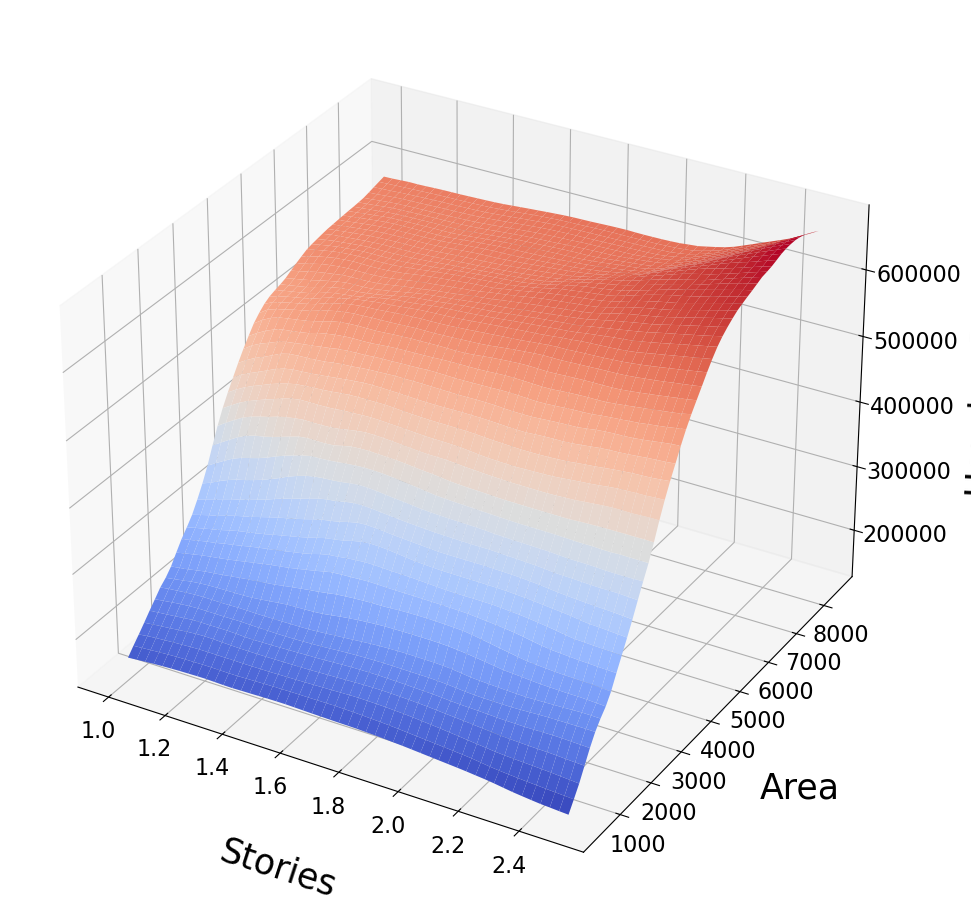

In [99]:
# Plot the 2-way partial dependence plot
%matplotlib inline
plot_3d("Stories", "Area")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


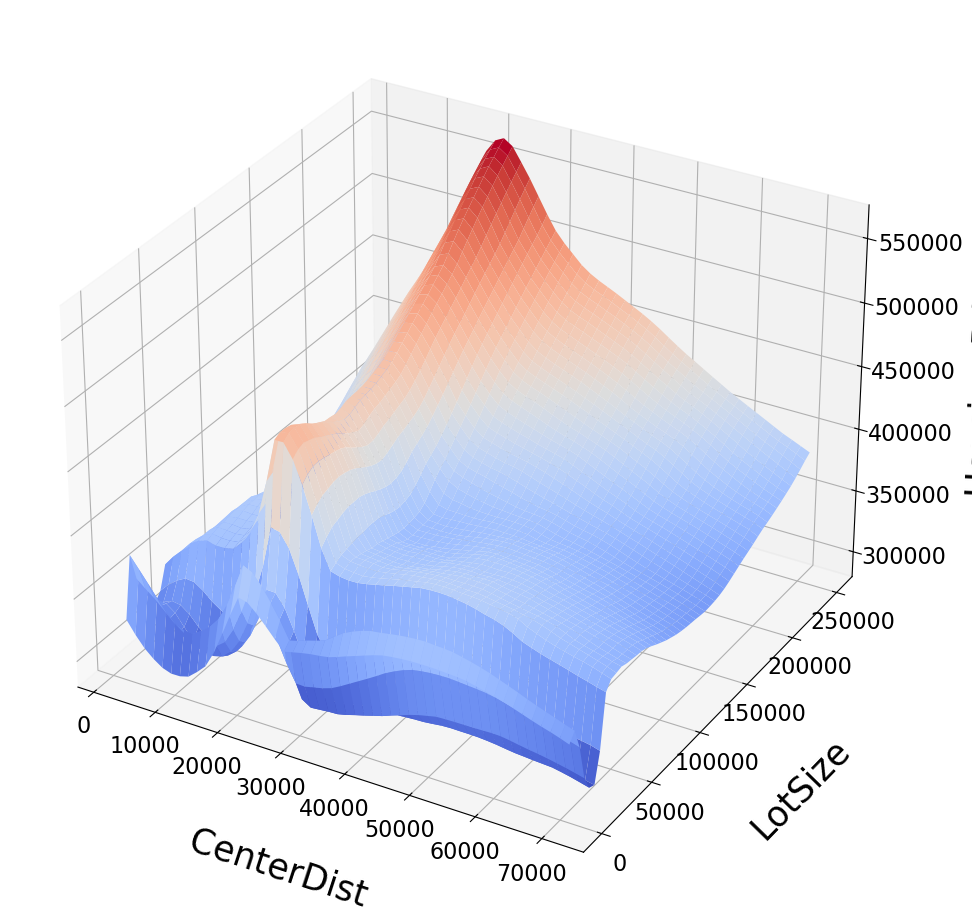

In [100]:
# Plot the 2-way partial dependence plot
%matplotlib inline
plot_3d("CenterDist", "LotSize")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


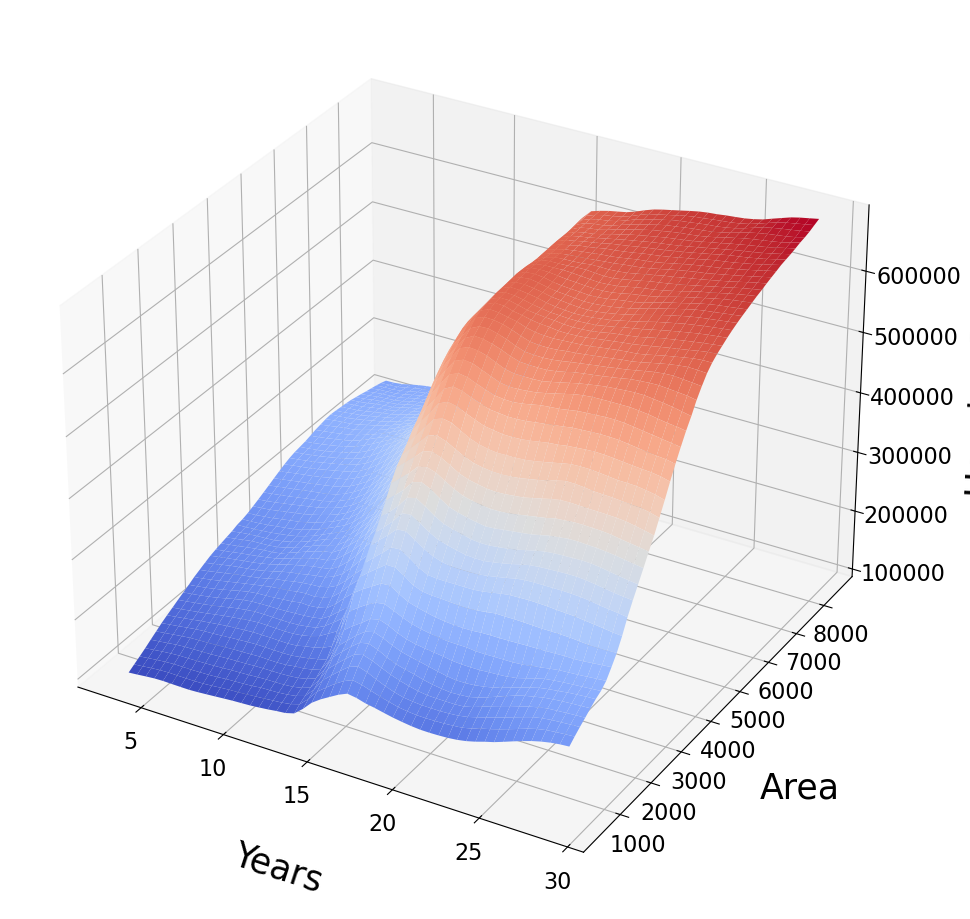

In [101]:
# Plot the 2-way partial dependence plot
%matplotlib inline
plot_3d("Years", "Area")

# Sobol method for variance-based sensitivity analysis

In [71]:
# Generate input values using Saltelli sampler
problem = {
    'num_vars': X.shape[1],
    'names': ['input_var_{}'.format(i) for i in range(X.shape[1])],
    'bounds': [[np.min(X_train[:, i]), np.max(X_train[:, i])] for i in range(X.shape[1])],
}

In [72]:
# Generate input values using Saltelli sampler
np.random.seed(42)
param_values = saltelli.sample(problem, 2**14, calc_second_order=True)

C:\Users\wanh535\AppData\Local\Temp\ipykernel_22696\1744386303.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**14, calc_second_order=True)


In [73]:
# Evaluate neural network model on input values generated by Saltelli sampler
Y_Saltelli1 = model1.predict(param_values)
Y_Saltelli1 = Y_Saltelli1.ravel()

Y_Saltelli2 = model2.predict(param_values)
Y_Saltelli2 = Y_Saltelli2.ravel()

Y_Saltelli3 = model3.predict(param_values)
Y_Saltelli3 = Y_Saltelli3.ravel()

Y_Saltelli4 = model4.predict(param_values)
Y_Saltelli4 = Y_Saltelli4.ravel()

Y_Saltelli5 = model5.predict(param_values)
Y_Saltelli5 = Y_Saltelli5.ravel()


8192/8192 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [74]:
Y_Saltelli = np.vstack([Y_Saltelli1, Y_Saltelli2, Y_Saltelli3, Y_Saltelli4, Y_Saltelli5])

In [79]:
Y_Saltelli_mean = np.mean(Y_Saltelli, axis = 0)

In [76]:
# Model 3 has the highest accuracy, thus it is used for generating second-order Sobol indices
Si = sobol.analyze(problem, Y_Saltelli3, calc_second_order = True, conf_level=0.95, num_resamples=1000)

C:\Users\wanh535\AppData\Local\anaconda3\envs\spatial_python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [102]:
# Perform Sobol-based sensitivity analysis
Si1 = sobol.analyze(problem, Y_Saltelli1, calc_second_order=True, conf_level=0.95, num_resamples=1000)
Si2 = sobol.analyze(problem, Y_Saltelli2, calc_second_order=True, conf_level=0.95, num_resamples=1000)
Si3 = sobol.analyze(problem, Y_Saltelli3, calc_second_order=True, conf_level=0.95, num_resamples=1000)
Si4 = sobol.analyze(problem, Y_Saltelli4, calc_second_order=True, conf_level=0.95, num_resamples=1000)
Si5 = sobol.analyze(problem, Y_Saltelli5, calc_second_order=True, conf_level=0.95, num_resamples=1000)

C:\Users\wanh535\AppData\Local\anaconda3\envs\spatial_python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


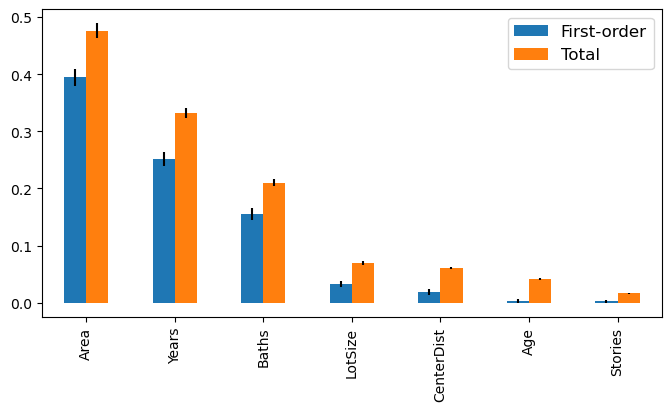

In [105]:
# Plot 1-st order and total-order sobol sensitivity index
names = predictors.columns.tolist()
Si_filter = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(Si_filter, index=names)
Si_df = Si_df.sort_values('S1', ascending=False)

fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 4)

legend_names = ["First-order", "Total"]
ax.legend(legend_names, fontsize=12)

plt.show()

In [114]:
#Model 5 is the optimal ANNs among the 5, so it is used for second-order Sobol plot
S2 = Si['S2']
S2 = S2[~np.isnan(S2)]
S2_conf = Si['S2_conf']
S2_conf = S2_conf[~np.isnan(S2_conf)]
df2 = pd.DataFrame(np.vstack((S2, S2_conf))).T
from itertools import combinations
df2.index = list(combinations(predictors.columns.tolist(), 2))
df2.columns = ["S2", "S2_conf"]

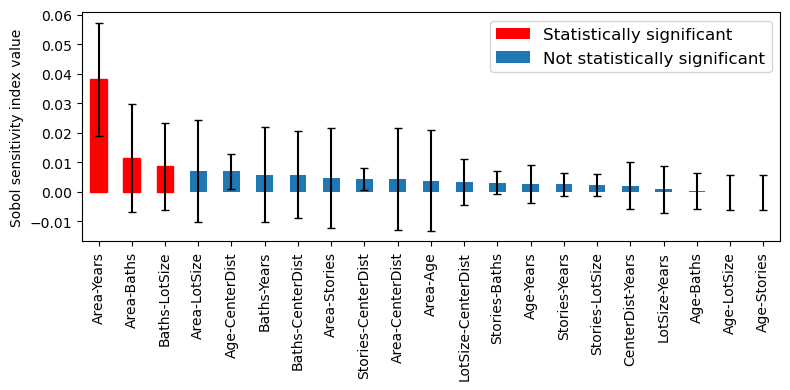

In [115]:
# Plot second-order sobol sensitivity index
%matplotlib inline
df2 = df2.sort_values('S2', ascending=False)
labels = [f"{pair[0]}-{pair[1]}" for pair in df2.index]

fig, ax = plt.subplots(1)

indices = df2[["S2"]]
err = df2[["S2_conf"]]

bars = indices.plot.bar(yerr=err.values.T, capsize=3, ax=ax)
for i in np.array([0, 1, 2]):
    bars.get_children()[i].set_color('red')

fig.set_size_inches(8, 4)

color_patches = [plt.Rectangle((0, 0), 1, 1, fc='red'), plt.Rectangle((0, 0), 1, 1, fc=bars.get_children()[3].get_facecolor())]

# Set the legend with color labels
legend_names = ["Statistically significant", "Not statistically significant"]
ax.legend(color_patches, legend_names, fontsize=12)

plt.ylabel("Sobol sensitivity index value")
ax.set_xticklabels(labels)

fig.tight_layout()

plt.show()
